<h1>Skin Lesions Detection Using Deep Learning</h1>

<h3>Model Training</h3>

<h3>Import Libraries</h3>

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


<h3>Configure Device</h3>

In [3]:
# Configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


<h3>Define Data Transformations</h3>

In [4]:
# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),  # Add vertical flip
        transforms.RandomRotation(30),    # Increase rotation
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # Larger scale range
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Add hue
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

<h3>Load Dataset and Create DataFrame</h3>

In [5]:
# Load Dataset and Create DataFrame

data_dir = "/kaggle/input/dataset-with-unknown-class/dataset"

# Create a balanced dataset DataFrame
def create_sample_df(dataset_dir, samples_per_class=100):
    all_data = []
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            image_files = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('png', 'jpg', 'jpeg'))]
            sampled_files = np.random.choice(image_files, samples_per_class, replace=len(image_files) < samples_per_class)
            all_data.extend([(img, class_name) for img in sampled_files])
    return pd.DataFrame(all_data, columns=["image", "label"])

sample_df = create_sample_df(os.path.join(data_dir, 'train'), samples_per_class=500)


<h3>Encode Labels and Split Dataset</h3>

In [6]:
# Encode Labels and Split Dataset
# Encode labels
class_names = sorted(sample_df['label'].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
sample_df['label_idx'] = sample_df['label'].map(class_to_idx)

# Split into train, validation, and test sets (70/15/15)
train_df, test_val_df = train_test_split(sample_df, test_size=0.3, stratify=sample_df['label_idx'], random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df['label_idx'], random_state=42)


<h3>Custom Dataset and DataLoaders</h3>

In [7]:

# Custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['label_idx']
        image = datasets.folder.default_loader(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Datasets and dataloaders
train_dataset = CustomDataset(train_df, transform=data_transforms['train'])
val_dataset = CustomDataset(val_df, transform=data_transforms['val_test'])
test_dataset = CustomDataset(test_df, transform=data_transforms['val_test'])

dataloaders_dict = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False)
}

<h3>Load Pretrained Model</h3>

In [8]:
%%capture
# Load a pretrained EfficientNet model
model = models.efficientnet_b4(pretrained=True)
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))  # Number of lesion classes
)

model = model.to(device)
print(model)

<h3>Define Loss Function, Optimizer and Scheduler
</h3>

In [9]:

# Define loss function with class weights
class_counts = sample_df['label'].value_counts()
class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer and scheduler
optimizer = optim.RAdam(model.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


<h3>Train the Model</h3>

Epoch 1/60


Train: 100%|██████████| 88/88 [01:17<00:00,  1.14it/s]


Train Loss: 2.0643 Acc: 0.1846


Val: 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]


Val Loss: 2.0244 Acc: 0.4333
Epoch 2/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.32it/s]


Train Loss: 1.8569 Acc: 0.3896


Val: 100%|██████████| 19/19 [00:06<00:00,  3.07it/s]


Val Loss: 1.4811 Acc: 0.4917
Epoch 3/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.32it/s]


Train Loss: 1.2753 Acc: 0.5196


Val: 100%|██████████| 19/19 [00:06<00:00,  3.11it/s]


Val Loss: 0.9283 Acc: 0.6733
Epoch 4/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.32it/s]


Train Loss: 0.9585 Acc: 0.6407


Val: 100%|██████████| 19/19 [00:06<00:00,  3.09it/s]


Val Loss: 0.7822 Acc: 0.6967
Epoch 5/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.32it/s]


Train Loss: 0.8288 Acc: 0.6864


Val: 100%|██████████| 19/19 [00:06<00:00,  2.88it/s]


Val Loss: 0.6699 Acc: 0.7467
Epoch 6/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.32it/s]


Train Loss: 0.7253 Acc: 0.7296


Val: 100%|██████████| 19/19 [00:06<00:00,  3.06it/s]


Val Loss: 0.5811 Acc: 0.7683
Epoch 7/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.32it/s]


Train Loss: 0.6620 Acc: 0.7521


Val: 100%|██████████| 19/19 [00:06<00:00,  3.06it/s]


Val Loss: 0.5124 Acc: 0.8183
Epoch 8/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.32it/s]


Train Loss: 0.5955 Acc: 0.7800


Val: 100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Val Loss: 0.4812 Acc: 0.8133
Epoch 9/60


Train: 100%|██████████| 88/88 [01:07<00:00,  1.31it/s]


Train Loss: 0.5541 Acc: 0.7957


Val: 100%|██████████| 19/19 [00:06<00:00,  2.90it/s]


Val Loss: 0.4663 Acc: 0.8150
Epoch 10/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.33it/s]


Train Loss: 0.5160 Acc: 0.8082


Val: 100%|██████████| 19/19 [00:06<00:00,  3.06it/s]


Val Loss: 0.4587 Acc: 0.8267
Epoch 11/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.33it/s]


Train Loss: 0.4646 Acc: 0.8268


Val: 100%|██████████| 19/19 [00:06<00:00,  2.93it/s]


Val Loss: 0.4480 Acc: 0.8267
Epoch 12/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.33it/s]


Train Loss: 0.4198 Acc: 0.8436


Val: 100%|██████████| 19/19 [00:06<00:00,  3.09it/s]


Val Loss: 0.4323 Acc: 0.8350
Epoch 13/60


Train: 100%|██████████| 88/88 [01:05<00:00,  1.33it/s]


Train Loss: 0.3911 Acc: 0.8579


Val: 100%|██████████| 19/19 [00:06<00:00,  3.09it/s]


Val Loss: 0.4121 Acc: 0.8433
Epoch 14/60


Train: 100%|██████████| 88/88 [01:05<00:00,  1.34it/s]


Train Loss: 0.3504 Acc: 0.8711


Val: 100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Val Loss: 0.3862 Acc: 0.8467
Epoch 15/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.32it/s]


Train Loss: 0.3405 Acc: 0.8721


Val: 100%|██████████| 19/19 [00:06<00:00,  2.99it/s]


Val Loss: 0.4060 Acc: 0.8383
Epoch 16/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.33it/s]


Train Loss: 0.3102 Acc: 0.8871


Val: 100%|██████████| 19/19 [00:06<00:00,  3.11it/s]


Val Loss: 0.4087 Acc: 0.8500
Epoch 17/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.33it/s]


Train Loss: 0.2594 Acc: 0.9039


Val: 100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Val Loss: 0.4507 Acc: 0.8517
Epoch 18/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.33it/s]


Train Loss: 0.2670 Acc: 0.8986


Val: 100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Val Loss: 0.4139 Acc: 0.8583
Epoch 19/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.32it/s]


Train Loss: 0.2242 Acc: 0.9193


Val: 100%|██████████| 19/19 [00:06<00:00,  2.99it/s]


Val Loss: 0.4609 Acc: 0.8533
Epoch 20/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.32it/s]


Train Loss: 0.2056 Acc: 0.9289


Val: 100%|██████████| 19/19 [00:06<00:00,  3.02it/s]


Val Loss: 0.4804 Acc: 0.8567
Epoch 21/60


Train: 100%|██████████| 88/88 [01:05<00:00,  1.33it/s]


Train Loss: 0.2063 Acc: 0.9296


Val: 100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


Val Loss: 0.4555 Acc: 0.8567
Epoch 22/60


Train: 100%|██████████| 88/88 [01:09<00:00,  1.27it/s]


Train Loss: 0.1739 Acc: 0.9407


Val: 100%|██████████| 19/19 [00:06<00:00,  3.11it/s]


Val Loss: 0.4842 Acc: 0.8650
Epoch 23/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.33it/s]


Train Loss: 0.1770 Acc: 0.9382


Val: 100%|██████████| 19/19 [00:06<00:00,  3.14it/s]


Val Loss: 0.4419 Acc: 0.8717
Epoch 24/60


Train: 100%|██████████| 88/88 [01:05<00:00,  1.34it/s]


Train Loss: 0.1705 Acc: 0.9421


Val: 100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Val Loss: 0.5107 Acc: 0.8600
Epoch 25/60


Train: 100%|██████████| 88/88 [01:05<00:00,  1.34it/s]


Train Loss: 0.1753 Acc: 0.9404


Val: 100%|██████████| 19/19 [00:06<00:00,  3.16it/s]


Val Loss: 0.5147 Acc: 0.8683
Epoch 26/60


Train: 100%|██████████| 88/88 [01:05<00:00,  1.33it/s]


Train Loss: 0.1316 Acc: 0.9571


Val: 100%|██████████| 19/19 [00:06<00:00,  3.10it/s]


Val Loss: 0.5245 Acc: 0.8667
Epoch 27/60


Train: 100%|██████████| 88/88 [01:06<00:00,  1.33it/s]


Train Loss: 0.1370 Acc: 0.9529


Val: 100%|██████████| 19/19 [00:06<00:00,  3.08it/s]


Val Loss: 0.5689 Acc: 0.8583
Epoch 28/60


Train: 100%|██████████| 88/88 [01:05<00:00,  1.33it/s]


Train Loss: 0.1120 Acc: 0.9621


Val: 100%|██████████| 19/19 [00:06<00:00,  2.79it/s]


Val Loss: 0.5128 Acc: 0.8667
Early stopping triggered.
Best Validation Accuracy: 0.8717


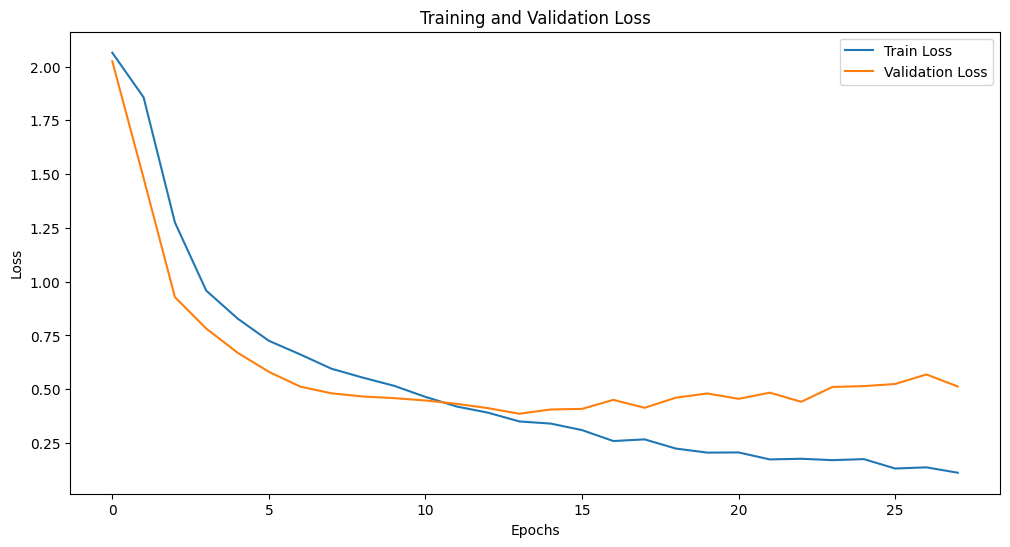

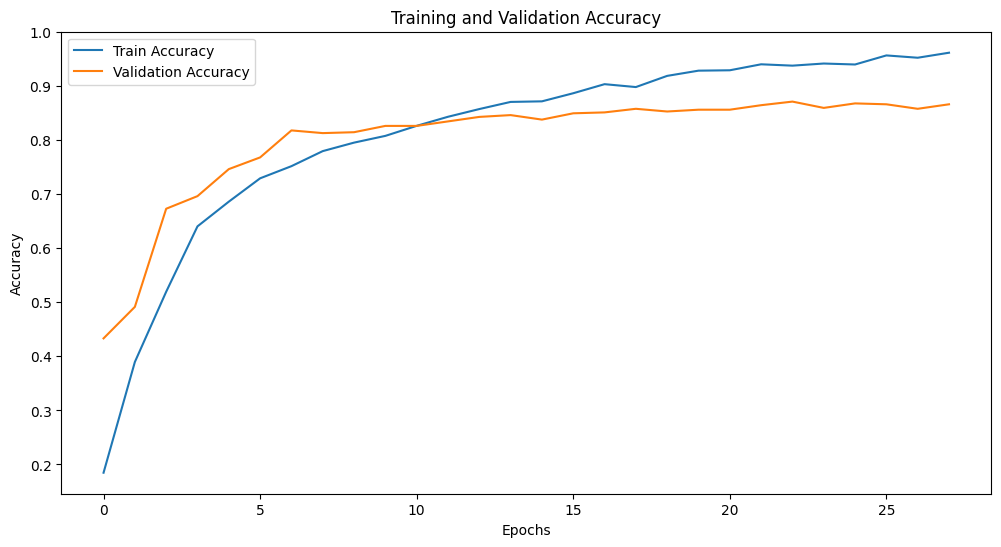

In [10]:
# Training function with fine-tuning and early stopping
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=60, patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    early_stopping_counter = 0
    train_loss, train_acc, val_loss, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase.capitalize()}"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.item())
            elif phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.item())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val':
                scheduler.step(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    # Plot loss and accuracy trends
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")
    plt.show()

    return model

# Train the model
model = train_model(model, dataloaders_dict, criterion, optimizer, scheduler)

<h3>Evaluate Model</h3>

Evaluating: 100%|██████████| 19/19 [00:06<00:00,  3.02it/s]


Classification Report:
              precision    recall  f1-score   support

       akiec       0.91      0.91      0.91        75
         bcc       0.94      0.97      0.95        75
         bkl       0.74      0.72      0.73        75
          df       1.00      1.00      1.00        75
         mel       0.77      0.64      0.70        75
          nv       0.75      0.88      0.81        75
     unknown       1.00      1.00      1.00        75
        vasc       0.99      0.97      0.98        75

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



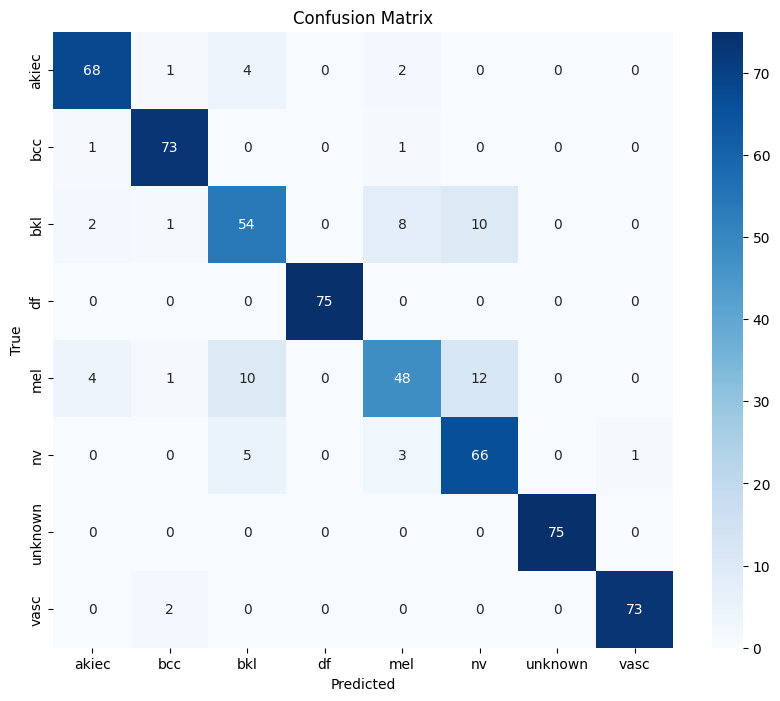

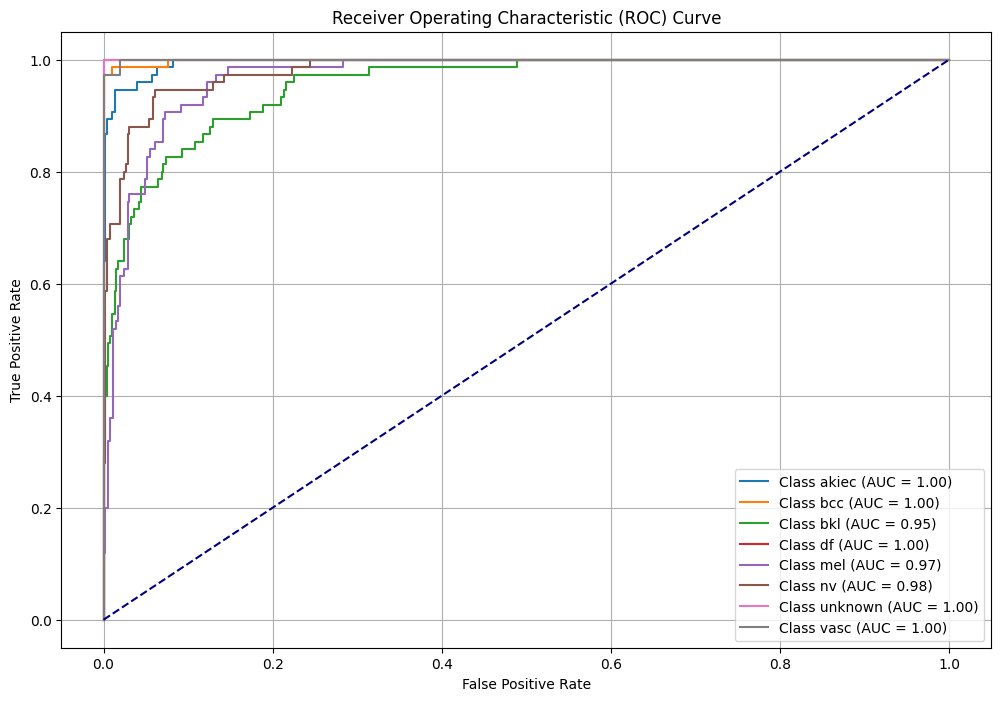

In [14]:
# Evaluate model on test set
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(outputs.cpu().numpy())  # Collect raw logits for ROC

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Plot ROC Curve
    plot_roc_curve(all_labels, all_logits, class_names)

    return all_labels, all_preds

# Function to Plot ROC Curve
def plot_roc_curve(labels, logits, class_names):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc
    import numpy as np

    # Binarize labels for ROC curve
    labels_binarized = label_binarize(labels, classes=range(len(class_names)))
    logits_probs = np.array([torch.softmax(torch.tensor(logit), dim=0).numpy() for logit in logits])  # Convert logits to probabilities

    n_classes = len(class_names)
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], logits_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(12, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

    # Plot the diagonal
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Call the evaluation function
test_labels, test_preds = evaluate_model(model, dataloaders_dict['test'], class_names)


<h3>Save the model</h3>

In [15]:
torch.save(model,'skin_unknown.pth')